# RLCT estimation method - sanity check
---

This notebook is just to implement MCMC based RLCT estimation method using elementary numerical computation libraries for sanity check purpose. 

For this purpose, we will estimate the RLCT for the $d = 2$ model 
$$
 y = a \tanh(b x) + \eta, \quad \eta \sim N(0, \sigma^2)
$$
at different true parameters. We expect 
 - When the truth is regular for the model (when $w_0$ is away from $ab = 0$), we should get $\lambda = d/2 = 1$. 
 - When the truth is singular for the model (when $w_0$ is on $ab = 0$), we should get $\lambda = 1/2$. 


In [1]:
import matplotlib
import matplotlib.pyplot as plt

import jax
from jax import vmap
import jax.numpy as jnp
import jax.random as random

import scipy
import numpy as np 


import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import os

# Set up truth and data

In [6]:
def tanh_reg_func(x, w, h=1):
    num_samples, input_dim = x.shape
    asize = input_dim * h
    a = w[:asize].reshape(input_dim, h)
    b = w[asize:].reshape(h, -1)
    return jnp.matmul(jnp.tanh(jnp.matmul(x, a)), b)

reg_func = jax.jit(tanh_reg_func, static_argnums=(2))
grad_reg_func = jax.grad(reg_func)

true param: [0. 0.]


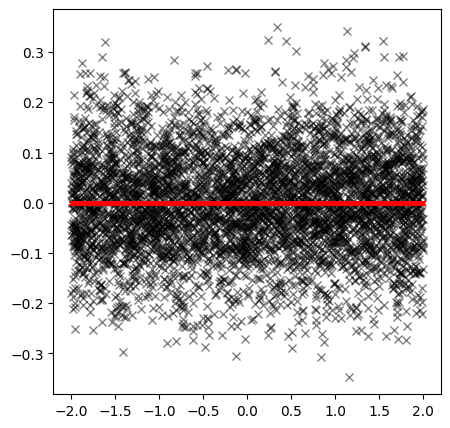

In [26]:
a_0 = jnp.array( # dim = (input_dim, h)
    [[0.0]]
)
b_0 = jnp.array( # dim = (h, output_dim)
    [[0.0]]
).T
input_dim, h = a_0.shape
output_dim = b_0.shape[1]
sigma = 0.1
prior_sigma = 1.0

w_0 = jnp.hstack([jnp.ravel(a_0), jnp.ravel(b_0)])
print(f"true param: {w_0}")

rng_key, noise_key = random.split(random.PRNGKey(42))
num_training_samples = 5023

xmin, xmax = -2.0, 2.0
X = (xmax - xmin) * random.uniform(rng_key, shape=(num_training_samples, input_dim)) + xmin
Y = reg_func(X, w_0, h=h) + random.normal(noise_key, (num_training_samples, output_dim)) * sigma

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(X, Y, "kx", alpha=0.5)
ax.plot(X, reg_func(X, w_0, h=h), "rx", markersize=3, alpha=0.5);

# Set up model

In [27]:
@jax.jit
def nll(X, Y, w, sigma=0.1):
    yhat = reg_func(X, w)
    ydist = dist.Normal(yhat, sigma)
    return -ydist.log_prob(Y).sum()

@jax.jit
def log_prior(w, sigma=1.0):
    return -1/ (2 * sigma**2) * jnp.sum(w**2)

@jax.jit
def log_prob(X, Y, w, sigma=0.1, prior_sigma=1.0, itemp=1.0):
    return -itemp * nll(X, Y, w, sigma=sigma) + log_prior(w, sigma=prior_sigma)


def proposal_distribution(x, step_size):
    return np.random.normal(x, step_size)

def target_distribution(w, X, Y, sigma=0.1, prior_sigma=1.0, itemp=1.0):
    return np.exp(log_prob(X, Y, w, sigma=sigma, prior_sigma=prior_sigma, itemp=itemp))

def rand_init(shape, sigma=1.0):
    return np.random.randn(*shape) * sigma

def metropolis_hastings(
    X, Y, sigma, prior_sigma,
    num_samples, 
    step_size, 
    sample_shape, 
    itemp=1.0, 
    initial_state=None, 
    num_chains=1, 
    verbose=False
):

    samples = np.zeros([num_samples * num_chains] + list(sample_shape))
    
    for c in range(num_chains):
        acceptance_counter = 0
        if initial_state is None:
            init = rand_init(sample_shape)
        else:
            init = initial_state
        state = init
        for i in range(num_samples):
            proposed_state = proposal_distribution(state, step_size)
            acceptance_ratio = (
                target_distribution(proposed_state, X, Y, sigma=sigma, prior_sigma=prior_sigma, itemp=itemp) /
                target_distribution(state, X, Y, sigma=sigma, prior_sigma=prior_sigma, itemp=itemp)
            )
            if np.random.uniform(0, 1) < acceptance_ratio:
                state = proposed_state
                acceptance_counter += 1

            samples[c * num_samples + i] = state
        if verbose:
            print(f"Chain: {c}, acceptance rate: {acceptance_counter / num_samples:.3f}")
    
    return samples

# Running MCMC to visualise the posterior

Observations: 
 - Step size of MH-MCMC needs to be carefully tuned depending on how concentrated the posterior is, which depends on `num_training_samples` and the temperature. High `n`, low temperature => need small step size and vice versa. 
 - When posterior is very concentrated (high `n` low temp), random MCMC initialisation will fail as it will be stuck waiting for a random jump towards a high probability region. In this case, starting near the true parameter works but isn't ideal as it won't explore other modes with small step sizes. 


/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_48773/314505435.py:18: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|████████████████████████████████████████████| 4500/4500 [00:01<00:00, 3461.92it/s, 7 steps of size 3.18e-01. acc. prob=0.76]


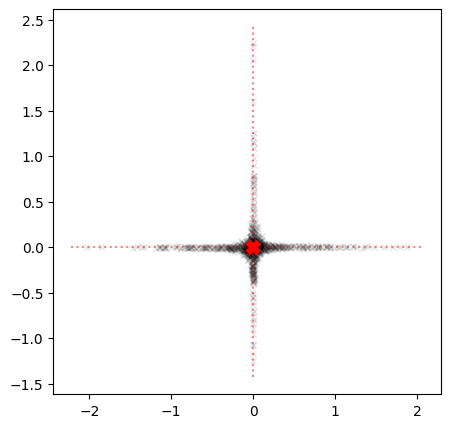

In [28]:
num_mcmc_step = 2000
num_chains = 5
thin = 10
# init_state = w_0
# init_state = None # random initialisation 
# init_state = jnp.zeros_like(w_0)
mcmc_step_size = 0.01
thin = 20
num_chains = 4

num_warmup = 500
num_posterior_samples = 4000
itemp = .1

def potential_func(w):
        return -log_prob(X, Y, w, sigma=sigma, prior_sigma=prior_sigma, itemp=itemp)
kernel = NUTS(potential_fn=potential_func)
mcmc = MCMC(
    kernel,
    num_warmup=num_warmup,
    num_samples=num_posterior_samples,
    num_chains=num_chains,
    thinning=thin, 
    progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
)
mcmc.run(
    rng_key, 
    init_params=np.random.rand(num_chains, *w_0.shape)
)
s = mcmc.get_samples()

# s = metropolis_hastings(
#     X, Y, sigma, prior_sigma, 
#     num_mcmc_step, 
#     mcmc_step_size,
#     sample_shape=tuple(w_0.shape), 
#     itemp=0.5, 
#     initial_state=init_state,
#     num_chains=num_chains,
#     verbose=True
# )
# s = s[::thin]

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(s[:, 0], s[:, 1], "kx", markersize=5, alpha=0.1)
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.plot([w_0[0]], [w_0[1]], "rX", markersize=10)
ax.hlines([0], xmin=xmin, xmax=xmax, linestyles="dotted", alpha=0.5, color='r')
ax.vlines([0], ymin=ymin, ymax=ymax, linestyles="dotted", alpha=0.5, color='r')


# Running MCMC for posterior at different temperatures 

In [31]:
n = num_training_samples
num_itemps = 10
itemps = np.linspace(
    1 / np.log(n) * (1 - 1 / np.sqrt(2 * np.log(n))),
    1 / np.log(n) * (1 + 1 / np.sqrt(2 * np.log(n))), 
    num_itemps
)
print(f"itemps={itemps}")

# num_mcmc_step = 20000
# init_state = w_0
# init_state = jnp.zeros_like(w_0)
# init_state = None
# mcmc_step_size = 0.01
thin = 4
num_chains = 4

num_warmup = 500
num_posterior_samples = 2000



enlls = []
for itemp in itemps:      
    def potential_func(w):
        return -log_prob(X, Y, w, sigma=sigma, prior_sigma=prior_sigma, itemp=itemp)
    kernel = NUTS(potential_fn=potential_func)
    mcmc = MCMC(
        kernel,
        num_warmup=num_warmup,
        num_samples=num_posterior_samples,
        num_chains=num_chains,
        thinning=thin, 
        progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
    )
    mcmc.run(
        rng_key, 
        init_params=np.random.rand(num_chains, *w_0.shape)
    )
    s = mcmc.get_samples()
#     s = metropolis_hastings(
#         X, Y, sigma, prior_sigma,
#         num_mcmc_step, 
#         mcmc_step_size, 
#         sample_shape=tuple(w_0.shape), 
#         itemp=itemp, 
#         initial_state=init_state,
#         num_chains=num_chains, 
#         verbose=True
#     )
    enll = np.mean([nll(X, Y, w_sample, sigma=sigma) for w_sample in s])
    print(f"itemp={itemp:.3f}, enll={enll:.3f}")
    enlls.append(enll)
    

/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_48773/2613759114.py:28: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


itemps=[0.08892207 0.09523857 0.10155508 0.10787158 0.11418809 0.12050459
 0.1268211  0.1331376  0.13945411 0.14577061]


sample: 100%|████████████████████████████████████████████| 2500/2500 [00:00<00:00, 3246.82it/s, 5 steps of size 2.24e-01. acc. prob=0.87]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_48773/2613759114.py:28: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


itemp=0.089, enll=-4392.865


sample: 100%|████████████████████████████████████████████| 2500/2500 [00:00<00:00, 3749.60it/s, 3 steps of size 2.46e-01. acc. prob=0.75]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_48773/2613759114.py:28: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


itemp=0.095, enll=-4393.092


sample: 100%|████████████████████████████████████████████| 2500/2500 [00:00<00:00, 3221.95it/s, 7 steps of size 1.78e-01. acc. prob=0.65]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_48773/2613759114.py:28: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


itemp=0.102, enll=-4393.336


sample: 100%|███████████████████████████████████████████| 2500/2500 [00:02<00:00, 1206.83it/s, 47 steps of size 4.42e-02. acc. prob=0.92]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_48773/2613759114.py:28: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


itemp=0.108, enll=-4393.631


sample: 100%|███████████████████████████████████████████| 2500/2500 [00:01<00:00, 2337.81it/s, 23 steps of size 1.76e-01. acc. prob=0.87]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_48773/2613759114.py:28: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


itemp=0.114, enll=-4394.004


sample: 100%|████████████████████████████████████████████| 2500/2500 [00:00<00:00, 3053.28it/s, 7 steps of size 7.21e-02. acc. prob=0.26]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_48773/2613759114.py:28: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


itemp=0.121, enll=-4393.688


sample: 100%|████████████████████████████████████████████| 2500/2500 [00:00<00:00, 3408.98it/s, 7 steps of size 2.98e-01. acc. prob=0.75]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_48773/2613759114.py:28: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


itemp=0.127, enll=-4393.669


sample: 100%|████████████████████████████████████████████| 2500/2500 [00:01<00:00, 1838.56it/s, 7 steps of size 1.20e-01. acc. prob=0.90]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_48773/2613759114.py:28: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


itemp=0.133, enll=-4394.374


sample: 100%|████████████████████████████████████████████| 2500/2500 [00:00<00:00, 2885.07it/s, 7 steps of size 2.70e-01. acc. prob=0.78]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_48773/2613759114.py:28: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


itemp=0.139, enll=-4393.952


sample: 100%|████████████████████████████████████████████| 2500/2500 [00:00<00:00, 3007.05it/s, 1 steps of size 1.83e-01. acc. prob=0.48]

itemp=0.146, enll=-4394.224


R^2=0.8273106922845233


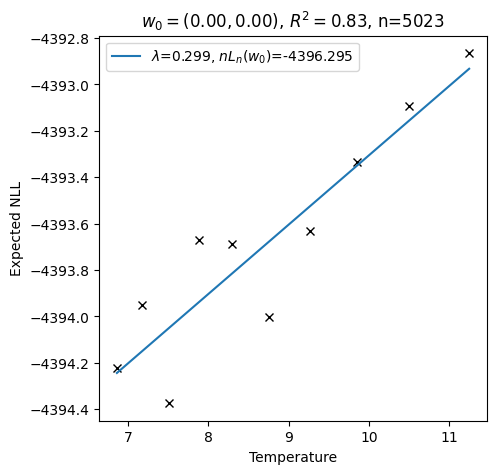

In [32]:
fig, ax = plt.subplots(figsize=(5,5))

slope, intercept, r_val, _, _ = scipy.stats.linregress(1 / itemps, enlls)
ax.plot(1/itemps, enlls, "kx")
ax.plot(1/itemps, 1/itemps * slope + intercept, label=f"$\lambda$={slope:.3f}, $nL_n(w_0)$={intercept:.3f}")
print(f"R^2={r_val**2}")

ax.legend()

ax.set_title(f"$w_0 = ({w_0[0]:.2f}, {w_0[1]:.2f})$, $R^2={r_val**2:.2f}$, n={num_training_samples}")
ax.set_xlabel("Temperature")
ax.set_ylabel("Expected NLL");

# Running the experiments for a range of  `n`

In [ ]:
%%time 
a_0 = jnp.array( # dim = (input_dim, h)
    [[0.5]]
)
b_0 = jnp.array( # dim = (h, output_dim)
    [[0.1]]
)
input_dim, h = a_0.shape
output_dim = b_0.shape[1]
sigma = 0.1
prior_sigma = 2.0

w_0 = jnp.hstack([jnp.ravel(a_0), jnp.ravel(b_0)])
print(f"true param: {w_0}")

# init_state = w_0
# mcmc_step_size = 0.05
thin = 10
num_chains = 4
num_warmup = 500
num_posterior_samples = 5000
num_itemps = 4

rng_key, noise_key = random.split(random.PRNGKey(42))

dataset_sizes = [10, 20, 30, 40, 100, 200, 300, 400, 800, 900, 1000, 3000, 5000]
ncols = num_itemps + 1
nrows = len(dataset_sizes) #// ncols + (len(dataset_sizes) % ncols != 0)
fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows))
itemp = 1.0
rng_key = random.PRNGKey(4)
xmin, xmax = -2.0, 2.0

rec = []

for i, num_training_samples in enumerate(dataset_sizes):
    n = num_training_samples
    X = (xmax - xmin) * random.uniform(rng_key, shape=(n, input_dim)) + xmin
    Y = reg_func(X, w_0, h=h) + random.normal(noise_key, (n, output_dim)) * sigma
    itemps = np.linspace(
        1 / np.log(n) * (1 - 1 / np.sqrt(2 * np.log(n))),
        1 / np.log(n) * (1 + 1 / np.sqrt(2 * np.log(n))), 
        num_itemps
    )

    enlls = []
    for j, itemp in enumerate(itemps):
        ax = axes[i][j]
        print(f"n={num_training_samples}, itemp={itemp:.3f}")
        def potential_func(w):
            return -log_prob(X, Y, w, sigma=sigma, prior_sigma=prior_sigma, itemp=itemp)
        kernel = NUTS(potential_fn=potential_func)
        mcmc = MCMC(
            kernel,
            num_warmup=num_warmup,
            num_samples=num_posterior_samples,
            num_chains=num_chains,
            thinning=thin, 
            progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
        )
        mcmc.run(
            rng_key, 
            init_params=np.random.rand(num_chains, *w_0.shape)
        )
        s = mcmc.get_samples()
        enll = np.mean([nll(X, Y, w_sample, sigma=0.1) for w_sample in s])
        enlls.append(enll)
        rec.append([n, itemp, enll])
        # plot posterior samples
        ax.scatter(s[:, 0], s[:, 1], marker="x", s=5, alpha=0.1)
        xmin, xmax = ax.get_xlim()
        ymin, ymax = ax.get_ylim()
        ax.hlines([0], xmin=xmin, xmax=xmax, linestyles="dotted", alpha=0.5, color='r')
        ax.vlines([0], ymin=ymin, ymax=ymax, linestyles="dotted", alpha=0.5, color='r')
        ax.plot([w_0[0]], [w_0[1]], "rX", markersize=10)
        ax.set_title(f"$n={num_training_samples}$, $\\beta={itemp:.3f}$", fontdict={"fontsize": 10})
    
    ax = axes[i][-1]
    slope, intercept, r_val, _, _ = scipy.stats.linregress(1 / itemps, enlls)
    ax.plot(1/itemps, enlls, "kx")
    ax.plot(1/itemps, 1/itemps * slope + intercept, label=f"$\lambda$={slope:.3f}, $L_n(w_0)$={intercept / n:.3f}")
    ax.legend(fontsize="x-small")
    ax.set_title(
        f"$w_0 = ({w_0[0]:.2f}, {w_0[1]:.2f})$, $R^2={r_val**2:.2f}$, n={num_training_samples}", 
        fontdict={"fontsize": 10}
    )
    ax.set_xlabel("Temperature")
    ax.set_ylabel("Expected NLL");



true param: [0.5 0.1]


<timed exec>:52: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.


n=10, itemp=0.232


sample: 100%|██████████████████████████████████████████| 5500/5500 [00:00<00:00, 14547.69it/s, 19 steps of size 1.99e-01. acc. prob=0.80]
<timed exec>:52: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.


n=10, itemp=0.367


sample: 100%|██████████████████████████████████████████| 5500/5500 [00:00<00:00, 14974.79it/s, 15 steps of size 1.90e-01. acc. prob=0.67]
<timed exec>:52: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.


n=10, itemp=0.502


sample: 100%|██████████████████████████████████████████| 5500/5500 [00:00<00:00, 14800.90it/s, 11 steps of size 3.04e-01. acc. prob=0.76]
<timed exec>:52: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.


n=10, itemp=0.637


sample: 100%|██████████████████████████████████████████| 5500/5500 [00:00<00:00, 12726.04it/s, 47 steps of size 3.91e-02. acc. prob=0.95]
<timed exec>:52: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.


n=20, itemp=0.197


sample: 100%|██████████████████████████████████████████| 5500/5500 [00:00<00:00, 14706.80it/s, 23 steps of size 1.98e-01. acc. prob=0.83]
<timed exec>:52: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.


n=20, itemp=0.288


sample: 100%|██████████████████████████████████████████| 5500/5500 [00:00<00:00, 14511.90it/s, 15 steps of size 2.22e-01. acc. prob=0.83]
<timed exec>:52: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.


n=20, itemp=0.379


sample: 100%|██████████████████████████████████████████| 5500/5500 [00:00<00:00, 15005.44it/s, 13 steps of size 2.10e-01. acc. prob=0.81]
<timed exec>:52: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.


n=20, itemp=0.470


sample: 100%|██████████████████████████████████████████| 5500/5500 [00:00<00:00, 14428.35it/s, 15 steps of size 2.16e-01. acc. prob=0.86]
<timed exec>:52: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.


n=30, itemp=0.181


sample: 100%|███████████████████████████████████████████| 5500/5500 [00:00<00:00, 14192.78it/s, 1 steps of size 4.12e-01. acc. prob=0.72]
<timed exec>:52: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.


n=30, itemp=0.256


sample: 100%|███████████████████████████████████████████| 5500/5500 [00:00<00:00, 14497.60it/s, 7 steps of size 2.33e-01. acc. prob=0.79]
<timed exec>:52: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.


n=30, itemp=0.332


sample: 100%|███████████████████████████████████████████| 5500/5500 [00:00<00:00, 14452.46it/s, 7 steps of size 1.91e-01. acc. prob=0.81]
<timed exec>:52: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.


n=30, itemp=0.407


sample: 100%|██████████████████████████████████████████| 5500/5500 [00:00<00:00, 14174.60it/s, 15 steps of size 2.21e-01. acc. prob=0.63]
<timed exec>:52: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.


n=40, itemp=0.171


sample: 100%|███████████████████████████████████████████| 5500/5500 [00:00<00:00, 14558.97it/s, 1 steps of size 2.40e-01. acc. prob=0.82]
<timed exec>:52: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.


n=40, itemp=0.238


sample: 100%|███████████████████████████████████████████| 5500/5500 [00:00<00:00, 14394.18it/s, 1 steps of size 3.94e-01. acc. prob=0.83]
<timed exec>:52: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.


n=40, itemp=0.304


sample: 100%|███████████████████████████████████████████| 5500/5500 [00:00<00:00, 13776.56it/s, 1 steps of size 3.03e-01. acc. prob=0.85]
<timed exec>:52: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.


n=40, itemp=0.371


sample: 100%|███████████████████████████████████████████| 5500/5500 [00:00<00:00, 13252.18it/s, 3 steps of size 9.98e-02. acc. prob=0.96]
<timed exec>:52: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.


n=100, itemp=0.146


sample: 100%|███████████████████████████████████████████| 5500/5500 [00:00<00:00, 14721.16it/s, 7 steps of size 1.90e-01. acc. prob=0.21]
<timed exec>:52: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.


n=100, itemp=0.193


sample: 100%|███████████████████████████████████████████| 5500/5500 [00:00<00:00, 14453.76it/s, 7 steps of size 3.19e-01. acc. prob=0.81]
<timed exec>:52: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.


n=100, itemp=0.241


sample: 100%|███████████████████████████████████████████| 5500/5500 [00:00<00:00, 14043.72it/s, 1 steps of size 3.00e-01. acc. prob=0.83]
<timed exec>:52: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.


n=100, itemp=0.289


sample: 100%|███████████████████████████████████████████| 5500/5500 [00:00<00:00, 14160.52it/s, 7 steps of size 4.60e-01. acc. prob=0.74]
<timed exec>:52: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.


n=200, itemp=0.131


sample: 100%|███████████████████████████████████████████| 5500/5500 [00:00<00:00, 12602.08it/s, 1 steps of size 1.87e-01. acc. prob=0.81]
<timed exec>:52: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.


n=200, itemp=0.169


sample: 100%|███████████████████████████████████████████| 5500/5500 [00:00<00:00, 10583.46it/s, 7 steps of size 2.34e-01. acc. prob=0.78]
<timed exec>:52: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.


n=200, itemp=0.208


sample: 100%|███████████████████████████████████████████| 5500/5500 [00:00<00:00, 12630.58it/s, 7 steps of size 2.55e-01. acc. prob=0.81]
<timed exec>:52: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.


n=200, itemp=0.247


sample: 100%|███████████████████████████████████████████| 5500/5500 [00:00<00:00, 12306.70it/s, 7 steps of size 2.52e-01. acc. prob=0.83]
<timed exec>:52: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.


n=300, itemp=0.123


sample: 100%|██████████████████████████████████████████| 5500/5500 [00:00<00:00, 12045.37it/s, 13 steps of size 1.29e-01. acc. prob=0.82]
<timed exec>:52: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.


n=300, itemp=0.158


sample: 100%|███████████████████████████████████████████| 5500/5500 [00:00<00:00, 12612.77it/s, 1 steps of size 1.82e-01. acc. prob=0.87]
<timed exec>:52: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.


n=300, itemp=0.193


sample: 100%|███████████████████████████████████████████| 5500/5500 [00:00<00:00, 12669.28it/s, 3 steps of size 1.65e-01. acc. prob=0.80]
<timed exec>:52: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.


n=300, itemp=0.227


sample: 100%|███████████████████████████████████████████| 5500/5500 [00:00<00:00, 12737.47it/s, 1 steps of size 1.34e-01. acc. prob=0.75]
<timed exec>:52: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.


n=400, itemp=0.119


sample: 100%|███████████████████████████████████████████| 5500/5500 [00:00<00:00, 12576.03it/s, 3 steps of size 2.28e-01. acc. prob=0.82]
<timed exec>:52: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.


n=400, itemp=0.151


sample: 100%|███████████████████████████████████████████| 5500/5500 [00:00<00:00, 12264.71it/s, 1 steps of size 1.76e-01. acc. prob=0.87]
<timed exec>:52: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.


n=400, itemp=0.183


sample: 100%|███████████████████████████████████████████| 5500/5500 [00:00<00:00, 12865.41it/s, 1 steps of size 2.41e-01. acc. prob=0.79]
<timed exec>:52: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.


n=400, itemp=0.215


sample: 100%|███████████████████████████████████████████| 5500/5500 [00:00<00:00, 13010.73it/s, 1 steps of size 2.38e-01. acc. prob=0.80]
<timed exec>:52: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.


n=800, itemp=0.109


sample: 100%|████████████████████████████████████████████| 5500/5500 [00:00<00:00, 6790.94it/s, 3 steps of size 6.24e-02. acc. prob=0.97]
<timed exec>:52: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.


n=800, itemp=0.136


sample: 100%|████████████████████████████████████████████| 5500/5500 [00:00<00:00, 9602.73it/s, 3 steps of size 1.14e-01. acc. prob=0.87]
<timed exec>:52: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.


n=800, itemp=0.163


sample: 100%|████████████████████████████████████████████| 5500/5500 [00:00<00:00, 9836.12it/s, 3 steps of size 1.46e-01. acc. prob=0.83]
<timed exec>:52: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.


n=800, itemp=0.191


sample: 100%|███████████████████████████████████████████| 5500/5500 [00:00<00:00, 10245.24it/s, 1 steps of size 1.62e-01. acc. prob=0.74]
<timed exec>:52: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.


n=900, itemp=0.107


sample: 100%|███████████████████████████████████████████| 5500/5500 [00:02<00:00, 2223.83it/s, 63 steps of size 1.91e-02. acc. prob=0.96]
<timed exec>:52: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.


n=900, itemp=0.134


sample: 100%|███████████████████████████████████████████| 5500/5500 [00:00<00:00, 8449.27it/s, 15 steps of size 8.68e-02. acc. prob=0.82]
<timed exec>:52: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.


n=900, itemp=0.160


sample: 100%|██████████████████████████████████████████| 5500/5500 [00:00<00:00, 11164.95it/s, 15 steps of size 1.56e-01. acc. prob=0.64]
<timed exec>:52: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.


n=900, itemp=0.187


sample: 100%|███████████████████████████████████████████| 5500/5500 [00:00<00:00, 10429.49it/s, 1 steps of size 2.15e-01. acc. prob=0.69]
<timed exec>:52: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.


n=1000, itemp=0.106


sample: 100%|███████████████████████████████████████████| 5500/5500 [00:00<00:00, 8633.68it/s, 15 steps of size 9.89e-02. acc. prob=0.78]
<timed exec>:52: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.


n=1000, itemp=0.132


sample: 100%|████████████████████████████████████████████| 5500/5500 [00:00<00:00, 9430.10it/s, 1 steps of size 1.27e-01. acc. prob=0.79]
<timed exec>:52: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.


n=1000, itemp=0.158


sample: 100%|███████████████████████████████████████████| 5500/5500 [00:01<00:00, 4821.58it/s, 23 steps of size 2.40e-02. acc. prob=0.91]
<timed exec>:52: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.


n=1000, itemp=0.184


sample: 100%|███████████████████████████████████████████| 5500/5500 [00:00<00:00, 8021.53it/s, 21 steps of size 8.46e-02. acc. prob=0.86]
<timed exec>:52: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.


n=3000, itemp=0.094


sample: 100%|████████████████████████████████████████████| 5500/5500 [00:02<00:00, 1929.52it/s, 3 steps of size 2.36e-02. acc. prob=0.90]
<timed exec>:52: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.


n=3000, itemp=0.114


sample: 100%|███████████████████████████████████████████| 5500/5500 [00:01<00:00, 3370.46it/s, 49 steps of size 6.85e-02. acc. prob=0.84]
<timed exec>:52: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.


n=3000, itemp=0.135


sample: 100%|████████████████████████████████████████████| 5500/5500 [00:02<00:00, 1849.14it/s, 1 steps of size 3.76e-02. acc. prob=0.87]
<timed exec>:52: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.


n=3000, itemp=0.156


sample: 100%|███████████████████████████████████████████| 5500/5500 [00:01<00:00, 4247.74it/s, 29 steps of size 1.37e-01. acc. prob=0.87]
<timed exec>:52: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.


n=5000, itemp=0.089


sample: 100%|███████████████████████████████████████████| 5500/5500 [00:02<00:00, 2260.00it/s, 39 steps of size 8.04e-02. acc. prob=0.86]
<timed exec>:52: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.


n=5000, itemp=0.108


sample: 100%|███████████████████████████████████████████| 5500/5500 [00:04<00:00, 1153.39it/s, 51 steps of size 3.31e-02. acc. prob=0.83]
<timed exec>:52: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.


n=5000, itemp=0.127


sample: 100%|█████████████████████████████████████████████| 5500/5500 [00:09<00:00, 584.90it/s, 3 steps of size 1.16e-02. acc. prob=0.94]
<timed exec>:52: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.


n=5000, itemp=0.146


sample: 100%|███████████████████████████████████████████| 5500/5500 [00:02<00:00, 1872.94it/s, 19 steps of size 6.51e-02. acc. prob=0.85]


CPU times: user 4min 8s, sys: 2.39 s, total: 4min 11s
Wall time: 4min 11s


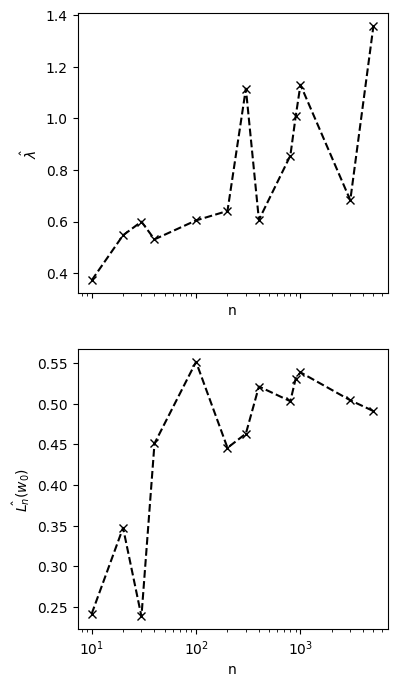

In [21]:
import pandas as pd
df = pd.DataFrame(rec, columns=["n", "itemp", "enll"])
g = df.groupby("n")

ns = []
lmbdas = []
energies = []
for n, dfx in g:
    itemps = dfx["itemp"]
    enlls = dfx["enll"]
    slope, intercept, r_val, _, _ = scipy.stats.linregress(1 / itemps, enlls)
    lmbdas.append(slope)
    ns.append(n)
    energies.append(intercept / n)
    
fig, axes = plt.subplots(2, 1, figsize=(4, 8), sharex=True)
ax = axes[0]
ax.plot(ns, lmbdas, "kx--")
ax.set_xlabel("n")
ax.set_ylabel("$\hat{\lambda}$");
ax.set_xscale("log")

ax = axes[1]
ax.plot(ns, energies, "kx--")
ax.set_xlabel("n")
ax.set_ylabel("$\hat{L_n}(w_0)$");
ax.set_xscale("log")
